<a href="https://colab.research.google.com/github/databyhuseyn/DeepLearning/blob/main/Transfer_Learning_in_Tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Get helper_functions.py script from Github
!wget https://raw.githubusercontent.com/databyhuseyn/DeepLearning/main/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2024-04-29 10:16:23--  https://raw.githubusercontent.com/databyhuseyn/DeepLearning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-04-29 10:16:23 (82.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# 10% of Food Data

In [8]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2024-04-29 10:19:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.207, 142.251.183.207, 142.251.180.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   210MB/s    in 0.8s    

2024-04-29 10:20:00 (210 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [10]:
# Walk through 10 percent data directory and list numbers of files
walk_through_dir('/content/10_food_classes_10_percent')

There are 2 directories and 0 images in '/content/10_food_classes_10_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '/content/10_food_classes_10_per

In [11]:
train_dir = '/content/10_food_classes_10_percent/train/'
test_dir = '/content/10_food_classes_10_percent/test/'

In [12]:
import tensorflow as tf
IMG_SIZE = (224, 224)
batch_size = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size = batch_size)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size = IMG_SIZE,
                                                                           label_mode='categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [22]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [19]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [20]:
# see and example batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[ 75.35714   44.816326  23.357143]
   [ 57.83163   34.545918  20.239796]
   [ 42.785713  28.15306   23.07653 ]
   ...
   [227.92854  195.98976   74.83685 ]
   [224.92856  192.2602    84.8827  ]
   [223.9694   189.61223   93.68377 ]]

  [[ 90.09694   55.857143  28.760202]
   [ 70.13776   42.0051    21.137754]
   [ 50.58673   31.428572  21.515306]
   ...
   [224.72961  192.87245   80.50011 ]
   [224.73972  191.80096   87.09183 ]
   [210.88248  178.5253    80.239655]]

  [[ 92.341835  53.265305  20.112244]
   [ 84.88265   52.984695  24.811226]
   [ 65.06632   38.44898   21.709185]
   ...
   [218.0305   185.4795    85.505005]
   [206.07654  174.71939   73.90306 ]
   [210.41853  181.41853   79.26545 ]]

  ...

  [[227.41843  209.41843   84.9899  ]
   [228.9847   209.21426   88.16835 ]
   [229.78574  209.12244   90.04591 ]
   ...
   [247.28067  230.49493  140.92346 ]
   [253.03067  236.51534  144.53058 ]
   [248.08153  232.29579  137.2906  ]]

  [[229.06628  209.06628   88.0662

# Transfer Learning

In [24]:
# Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# Freeze the base model
base_model.trainable = False

# Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# Pass the inputs into the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalizer)
x = base_model(inputs)
# Check data shape after passing it to base model
print(f'Shape after base_model: {x.shape}')

# Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'Shape after GlobalAveragePooling2D(): {x.shape}')

# Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# Combine the inputs with the outputs into a mode
model_0 = tf.keras.Model(inputs, outputs)

# Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics='accuracy')

# Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 callbacks=[create_tensorboard_callback('transfer_learning', '10_percent_feature_extract')])

Shape after base_model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20240429-105236
Epoch 1/5
24/24 [==============================] - 79s 3s/step - loss: 1.8894 - accuracy: 0.4227 - val_loss: 1.2917 - val_accuracy: 0.7484
Epoch 2/5
24/24 [==============================] - 77s 3s/step - loss: 1.1357 - accuracy: 0.7667 - val_loss: 0.8764 - val_accuracy: 0.8109
Epoch 3/5
24/24 [==============================] - 77s 3s/step - loss: 0.8318 - accuracy: 0.8253 - val_loss: 0.7052 - val_accuracy: 0.8322
Epoch 4/5
24/24 [==============================] - 73s 3s/step - loss: 0.6827 - accuracy: 0.8467 - val_loss: 0.6203 - val_accuracy: 0.8405
Epoch 5/5
24/24 [==============================] - 77s 3s/step - loss: 0.5869 - accuracy: 0.8760 - val_loss: 0.5695 - val_accuracy: 0.8470


In [30]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, '|', layer, '|', layer.name)

0 | <keras.src.engine.input_layer.InputLayer object at 0x7d9f72475720> | input_2
1 | <keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x7d9f72476470> | rescaling_1
2 | <keras.src.layers.preprocessing.normalization.Normalization object at 0x7d9f723417e0> | normalization_1
3 | <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d9f72326170> | stem_conv
4 | <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7d9f724f95a0> | stem_bn
5 | <keras.src.layers.core.activation.Activation object at 0x7d9f72327430> | stem_activation
6 | <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d9f724309a0> | block1a_project_conv
7 | <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7d9f72378160> | block1a_project_bn
8 | <keras.src.layers.core.activation.Activation object at 0x7d9f72432350> | block1a_project_activation
9 | <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d9f72378130> | block2a_ex

In [31]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, None, None, 3)        0         ['rescaling_1[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [32]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

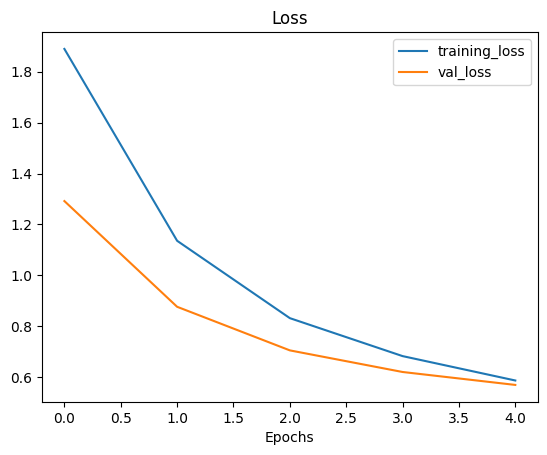

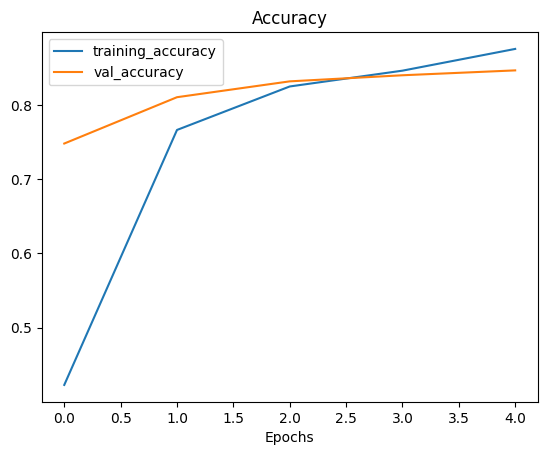

In [33]:
plot_loss_curves(history_10_percent)

In [35]:
# Define input tensor shape (same number of dimensions as the output of efficientnetv2-b0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor} \n')

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D global average pooled random tensor:\n {global_average_pooled_tensor} \n')

# Check the shapes of the different tensors
print(f'Shape of input tensor:{input_tensor.shape}')
print(f'Shape of 2D global averaged pooled input tensor:{global_average_pooled_tensor.shape}')

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]] 

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]] 

Shape of input tensor:(1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor:(1, 3)


In [36]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1, 2])     # average across the moddle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

# Running a series of transfer learning experiments

In [37]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2024-04-29 11:44:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.181.207, 64.233.182.207, 64.233.183.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.181.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  99.3MB/s    in 1.3s    

2024-04-29 11:45:01 (99.3 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [40]:
walk_through_dir('/content/10_food_classes_1_percent')

There are 2 directories and 0 images in '/content/10_food_classes_1_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/ice_cream

In [41]:
import tensorflow as tf

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           batch_size=batch_size,
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # preprocessing.Rescaling(1./255)   # keep for ResNet50V2, remove for EfficientNetV2B0
], name='data_augmentation')

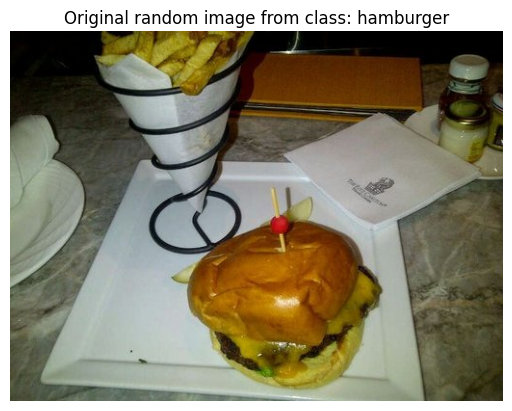

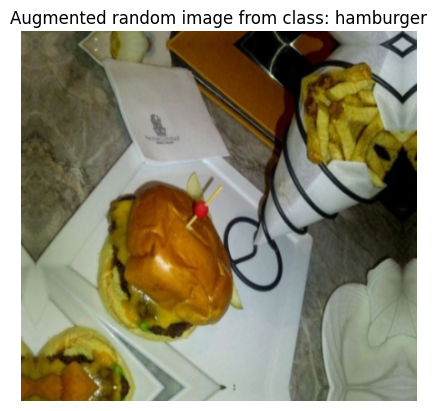

In [44]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)    # choose a random class
target_dir = '/content/10_food_classes_1_percent/train/' + target_class   # create target directory
random_image = random.choice(os.listdir(target_dir))      # choose a random image from target directory
random_image_path = target_dir + '/' + random_image       # Create the choosen random image path
img = mpimg.imread(random_image_path)         # plot the target image
plt.imshow(img)
plt.title(f'Original random image from class: {target_class}')
plt.axis(False)

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))      # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)      # requires normalization after augmentation
plt.title(f'Augmented random image from class: {target_class}')
plt.axis(False);

In [46]:
# Setup input shap and base model, freezing the base model layers
input_shape=(224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name='input_layer')

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics='accuracy')

# fit the model
model_1_history = model_1.fit(train_data_1_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_1_percent),
                              validation_data=test_data,
                              validation_steps=(0.25 * len(test_data)),
                              callbacks=[create_tensorboard_callback('transfer_learning', '1_percent_data_aug')])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240429-121943
Epoch 1/5
3/3 [==============================] - 58s 23s/step - loss: 2.3806 - accuracy: 0.1143 - val_loss: 2.1671 - val_accuracy: 0.1875
Epoch 2/5
3/3 [==============================] - 45s 22s/step - loss: 2.1727 - accuracy: 0.1429 - val_loss: 2.0608 - val_accuracy: 0.3109
Epoch 3/5
3/3 [==============================] - 36s 17s/step - loss: 2.0338 - accuracy: 0.3714 - val_loss: 1.9780 - val_accuracy: 0.3781
Epoch 4/5
3/3 [==============================] - 35s 17s/step - loss: 1.8074 - accuracy: 0.5429 - val_loss: 1.8958 - val_accuracy: 0.4297
Epoch 5/5
3/3 [==============================] - 35s 17s/step - loss: 1.6601 - accuracy: 0.6571 - val_loss: 1.8044 - val_accuracy: 0.4812


In [47]:
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 121s 2s/step - loss: 1.8089 - accuracy: 0.4836


[1.8088890314102173, 0.483599990606308]

# Model 2: Feature extraction transfer learning with 10 percent of data and data augmentation

In [57]:
train_dir_10 = '/content/10_food_classes_10_percent/train/'
test_dir_10 = '/content/10_food_classes_10_percent/test/'
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10,
                                                                            batch_size=batch_size,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical')
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir_10,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode='categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [58]:
base_model_2 = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model_2.trainable=False

In [59]:
inputs = layers.Input(shape=(224, 224, 3), name='input_layer')

x = data_augmentation(inputs)

x = base_model_2(x, training=False)

x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

model_2_augmented = keras.Model(inputs, outputs)

model_2_augmented.compile(loss='categorical_crossentropy',
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics='accuracy')

model_2_augmented.fit(train_data_10_percent,
                      epochs=5,
                      steps_per_epoch=len(train_data_10_percent),
                      validation_data=test_data_10_percent,
                      validation_steps=(0.25 * (len(train_data_10_percent))))

Epoch 1/5
24/24 [==============================] - 66s 2s/step - loss: 2.0556 - accuracy: 0.3173 - val_loss: 1.5621 - val_accuracy: 0.6458
Epoch 2/5
24/24 [==============================] - 53s 2s/step - loss: 1.4211 - accuracy: 0.6480 - val_loss: 1.0778 - val_accuracy: 0.7760
Epoch 3/5
24/24 [==============================] - 52s 2s/step - loss: 1.1119 - accuracy: 0.7240 - val_loss: 0.8626 - val_accuracy: 0.7969
Epoch 4/5
24/24 [==============================] - 53s 2s/step - loss: 0.9352 - accuracy: 0.7693 - val_loss: 0.7994 - val_accuracy: 0.8021
Epoch 5/5
24/24 [==============================] - 54s 2s/step - loss: 0.8490 - accuracy: 0.7720 - val_loss: 0.6809 - val_accuracy: 0.8073
